In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.sql import text
from dateutil.relativedelta import relativedelta
import re
from private import *
from train_models import * 

sns.set_style("whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [30]:

engine = create_engine('postgresql://',creator=connect)



In [31]:
query='''

SELECT *
FROM cars 
WHERE model in (SELECT DISTINCT MODEL
FROM cars
WHERE model in (SELECT model
FROM cars
GROUP BY model
HAVING COUNT(list_id)>10)
AND availability ='SOLD'
AND manufactured>2000 
AND price IS NOT NULL AND price>5 
AND reg_date IS NOT NULL
AND opc_scheme IS NULL
AND arf IS NOT NULL)
AND manufactured>2000 
AND price IS NOT NULL AND price>5 
AND reg_date IS NOT NULL
AND opc_scheme IS NULL
AND arf IS NOT NULL

'''


cars=pd.read_sql_query(query,engine)
cars.reset_index(drop=True,inplace=True)
cars.drop(columns=['index','level_0'],inplace=True)


In [32]:
cars.shape

(21398, 37)

In [33]:


# In[41]:


cars[['reg_date','date_posted','date_updated']]=cars[['reg_date','date_posted','date_updated']].applymap(lambda x:datetime.datetime.strptime(x.split()[0],'%Y-%m-%d'))
cars['date_scraped']=cars['date_scraped'].apply(lambda x:datetime.datetime.strptime(x.split()[0],'%d-%m-%Y'))


# In[42]:


# Fill missing values # 
cars['power']=cars[['power','brand']].groupby(cars['brand']).transform(lambda x: x.fillna(x.mean()))
cars['depreciation']=cars[['depreciation','brand']].groupby(cars['brand']).transform(lambda x: x.fillna(x.mean()))
cars['coe_cat']=cars['engine_cap'].apply(lambda x: 'CAT_A' if x <1600. else 'CAT_B')
cars['curb_weight']=cars[['curb_weight','type_of_veh']].groupby(cars['type_of_veh']).transform(lambda x: x.fillna(x.mean()))
cars['veh_age']=cars['date_posted'].dt.year-cars['reg_date'].dt.year
cars['veh_age_mths']=cars.date_posted.dt.to_period('M')-cars.reg_date.dt.to_period('M')
cars['veh_age_mths']=cars['veh_age_mths'].apply(lambda x: x.n)


# In[43]:


car_type_dummies=cars['category'].str.get_dummies(sep=', ')
labels=car_type_dummies.columns
car_type_dummies.columns=['is_'+x.lower().replace(' ','_') for x in labels]
cars=pd.concat([cars,car_type_dummies],axis=1)


# In[44]:


cars['has_5yr_COE']=cars['list_title'].str.contains('New 5-yr COE')
cars['has_10yr_COE']=cars['list_title'].str.contains('New 10-yr COE')
cars['has_COE_date']=cars['list_title'].str.contains('COE till')
cars['has_renewed_COE']=cars['has_5yr_COE']| cars['has_10yr_COE']|cars['has_COE_date']


# In[45]:


def coe_expiry(x):
    
    if x.has_5yr_COE:
        return x.date_posted + relativedelta(years=5)
    elif x.has_10yr_COE:
        return x.date_posted + relativedelta(years=10)
    elif x.has_COE_date:
        return datetime.datetime.strptime(re.search('\((.*?)\)',x.list_title).group(1).split('till ')[1],'%m/%Y')
    else: 
        return x.reg_date + relativedelta(years=10)
    
cars['coe_expiry_date']=cars.apply(lambda x:coe_expiry(x),axis=1)


def coe_my_update(x):

    if x.has_5yr_COE or x.has_10yr_COE:
        return x.date_posted.strftime('%b-%Y')
    elif x.has_COE_date:
        new_dt=x.reg_date + relativedelta(years=10)
        return new_dt.strftime('%b-%Y')
    else:
        return x.reg_date.strftime('%b-%Y')


cars['month_to_coe_expiry']=cars.coe_expiry_date.dt.to_period('M') - cars.date_posted.dt.to_period('M')
cars['month_to_coe_expiry']=cars['month_to_coe_expiry'].apply(lambda x: x.n)
cars['reg_my']=cars.apply(lambda x: coe_my_update(x),axis=1)


# In[46]:


cars['coe_my_cat']=cars['reg_my']+'-'+cars['coe_cat']


# In[47]:


coe_query='''
            SELECT coe_my_cat,value
            FROM coe_long
            '''
coe_long=pd.read_sql_query(coe_query,engine)

coe_fill_5=coe_long
coe_fill_5['value']=coe_long['value']/2

coe_miss_5=pd.merge(cars[['coe_my_cat','coe']][(cars['coe'].isna()) & cars['has_5yr_COE']],coe_fill_5,on='coe_my_cat',right_index=True)
cars['coe'].fillna(value=coe_miss_5['value'],inplace=True)

coe_miss_10=pd.merge(cars[['coe_my_cat','coe']][cars['coe'].isna()],coe_long,on='coe_my_cat',right_index=True)
cars['coe'].fillna(value=coe_miss_10['value'],inplace=True)


# In[48]:


def road_tax_calculator(x):
    base=0
    if x.engine_cap<=600:
        base=400*0.782
    if 600 < x.engine_cap <=1000:
        base=(400 + 0.25*(x.engine_cap - 600))*0.782
    if 1000 < x.engine_cap <= 1600:
        base=(500 + 0.75*(x.engine_cap - 1000))*0.782
    if 1600 < x.engine_cap <= 3000:
        base=(950 + 1.5*(x.engine_cap - 1600))*0.782
    if x.engine_cap>3000:
        base=(3050 + 2*(x.engine_cap-3000))*0.782
        
    if x.veh_age>10:
        return base*(1+0.1*(x.veh_age-10))
    else:
        return base
    
cars['road_tax'].fillna(cars[['engine_cap','veh_age']][cars['road_tax'].isna()].apply(lambda x: road_tax_calculator(x),axis=1),inplace=True)


# In[49]:


def coe_rebate_calculator(x):
    if x.has_5yr_COE:
        return x.coe*x.month_to_coe_expiry/60
    else:
        return x.coe*x.month_to_coe_expiry/120

cars['coe_rebate']=cars.apply(lambda x: coe_rebate_calculator(x),axis=1)


# In[50]:


def parf_calculator(x):
    if x.is_coe_car==1:
        return 0
    if x.veh_age<5:
        return 0.75*(x.arf)
    if 5<=x.veh_age<10:
        return (0.75-0.05*(x.veh_age-4))*(x.arf)
    if x.veh_age>=10:
        return 0
cars['parf_rebate']=cars[['veh_age','arf','is_coe_car']].apply(lambda x: parf_calculator(x),axis=1)
cars['dereg_value'].fillna(cars['parf_rebate'][cars['dereg_value'].isna()]+cars['coe_rebate'][cars['dereg_value'].isna()],inplace=True)


# In[51]:


cars['no_of_owners'].fillna(1,inplace=True)


# In[52]:


cars['fuel_type'].fillna('Petrol',inplace=True)
cars['fuel_type']=cars['fuel_type'].apply(lambda x: 'Diesel' if x.split(' ')[0]=='Diesel' else x)


# In[53]:


from sklearn.linear_model import LinearRegression

m=cars['mileage'][cars['mileage'].notna()]
age_lm=cars['veh_age_mths'][cars['mileage'].notna()]*cars['is_low_mileage_car'][cars['mileage'].notna()]
X=pd.concat([cars[['veh_age_mths','is_low_mileage_car']][cars['mileage'].notna()],age_lm],axis=1).values


X_miss=cars[['veh_age_mths','is_low_mileage_car']][cars['mileage'].isna()]
X_miss['interaction']=cars['veh_age_mths'][cars['mileage'].isna()]*cars['is_low_mileage_car'][cars['mileage'].isna()]

lr_impute=LinearRegression().fit(X,m)

mileage_miss=pd.Series(lr_impute.predict(X_miss),index=cars['mileage'][cars['mileage'].isna()].index)

cars['mileage'].fillna(mileage_miss,inplace=True)


# In[55]:


cars['value']=cars['price']-cars['dereg_value']


# In[58]:


cars=cars[cars['value']>0].reset_index(drop=True)



In [35]:
sold=cars[cars['availability']=='SOLD']

dealer_query='''
        SELECT DISTINCT list_id, l.dealer_id , d.company 
        FROM listings AS l
        LEFT JOIN (SELECT DISTINCT dealer_id, company, available_vehicles, sold_vehicles 
                    FROM dealers) as d on l.dealer_id= d.dealer_id
        WHERE company IS NOT NULL

'''
dealers=pd.read_sql_query(dealer_query,engine)

sell=pd.merge(sold,dealers,how='left',on='list_id')

In [42]:
model_dums=pd.get_dummies(cars['model'],drop_first=True)

In [43]:
features=['engine_cap','power','curb_weight','omv','mileage','veh_age_mths','month_to_coe_expiry']

In [44]:
X=pd.concat([cars[features],model_dums],axis=1)

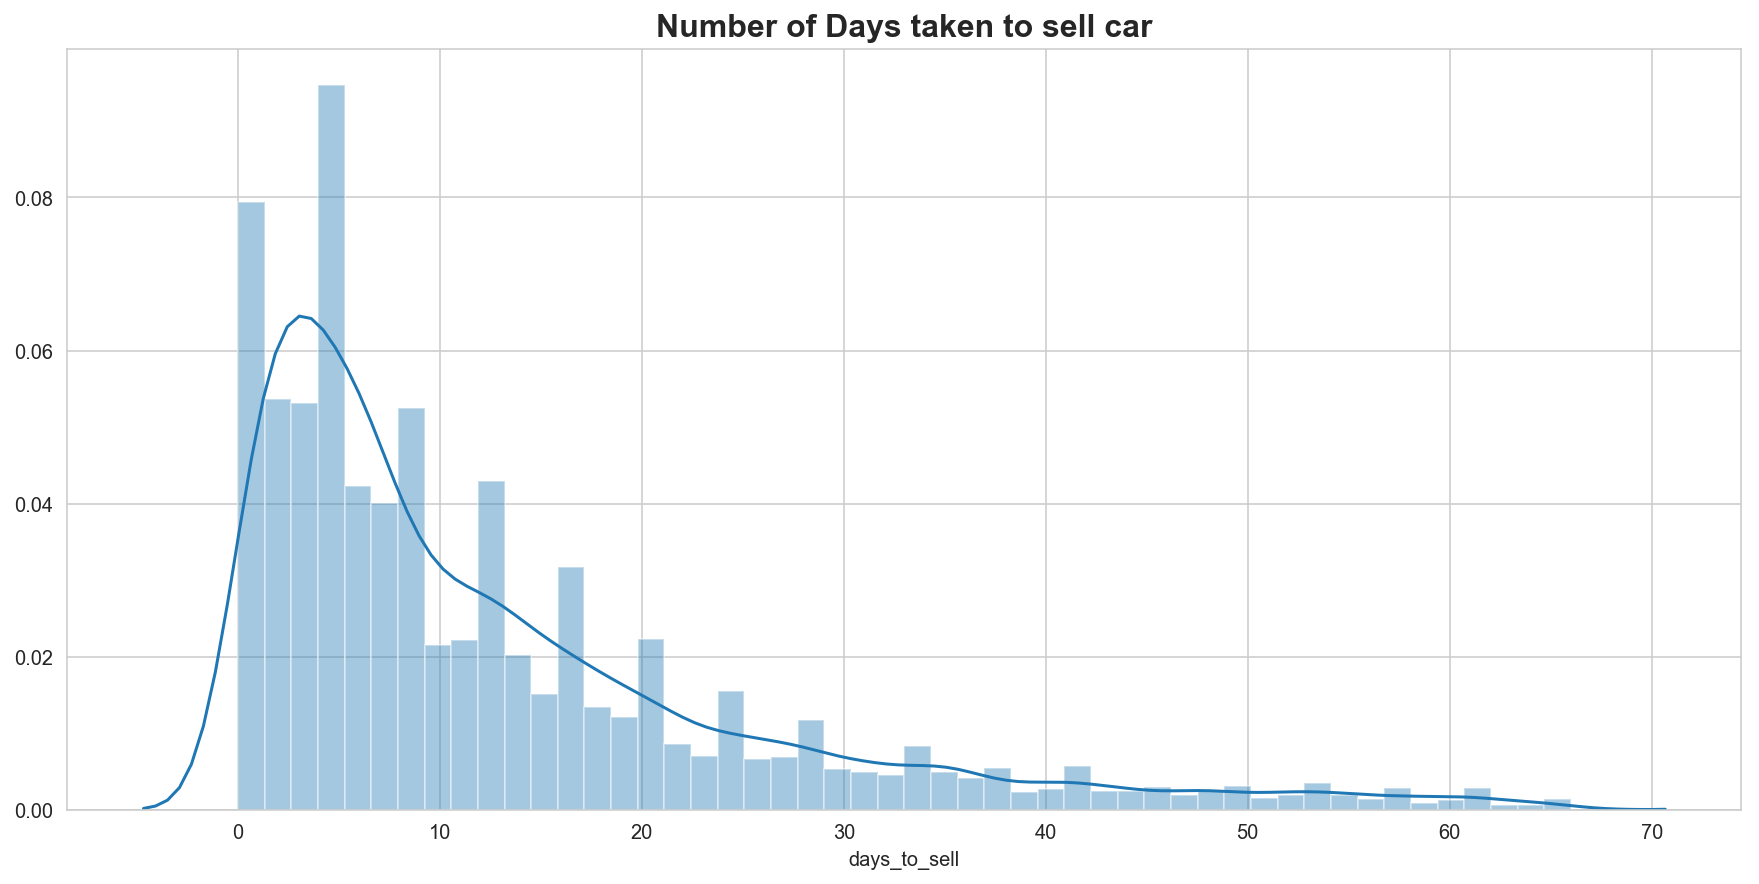

In [86]:
plt.figure(figsize=(15,7))
ax=sns.distplot(sell['days_to_sell'])

plt.title('Number of Days taken to sell car', fontweight='bold',fontsize=16)
plt.show()


In [29]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [30]:
cats=car_type_dummies.columns.to_list()
@interact
def scatter_plot(x=list(sell.select_dtypes('number').columns), 
                 y=list(sell.select_dtypes('number').columns),
                hue=cats):
    plt.figure(figsize=(10,8))
    ax=sns.scatterplot(x=x,y=y,data=sell,hue=hue)
    ax.set_title('{} vs {}'.format(x.title(),y.title()),fontsize=16,fontweight='bold')

interactive(children=(Dropdown(description='x', options=('arf', 'coe', 'curb_weight', 'days_to_sell', 'depreci…

In [54]:
sold10=sell['company'].isin(sell['company'].value_counts()[sell['company'].value_counts()>10].index.to_list())
companies_sub=sell[['days_to_sell','company']][sold10].groupby(by='company').mean().sort_values(by='days_to_sell')
top_dealers=companies_sub[companies_sub['days_to_sell']<=7].index.to_list()
top_dealer=sell['company'].isin(top_dealers)
sell['is_top_dealer']=top_dealer.astype(int)

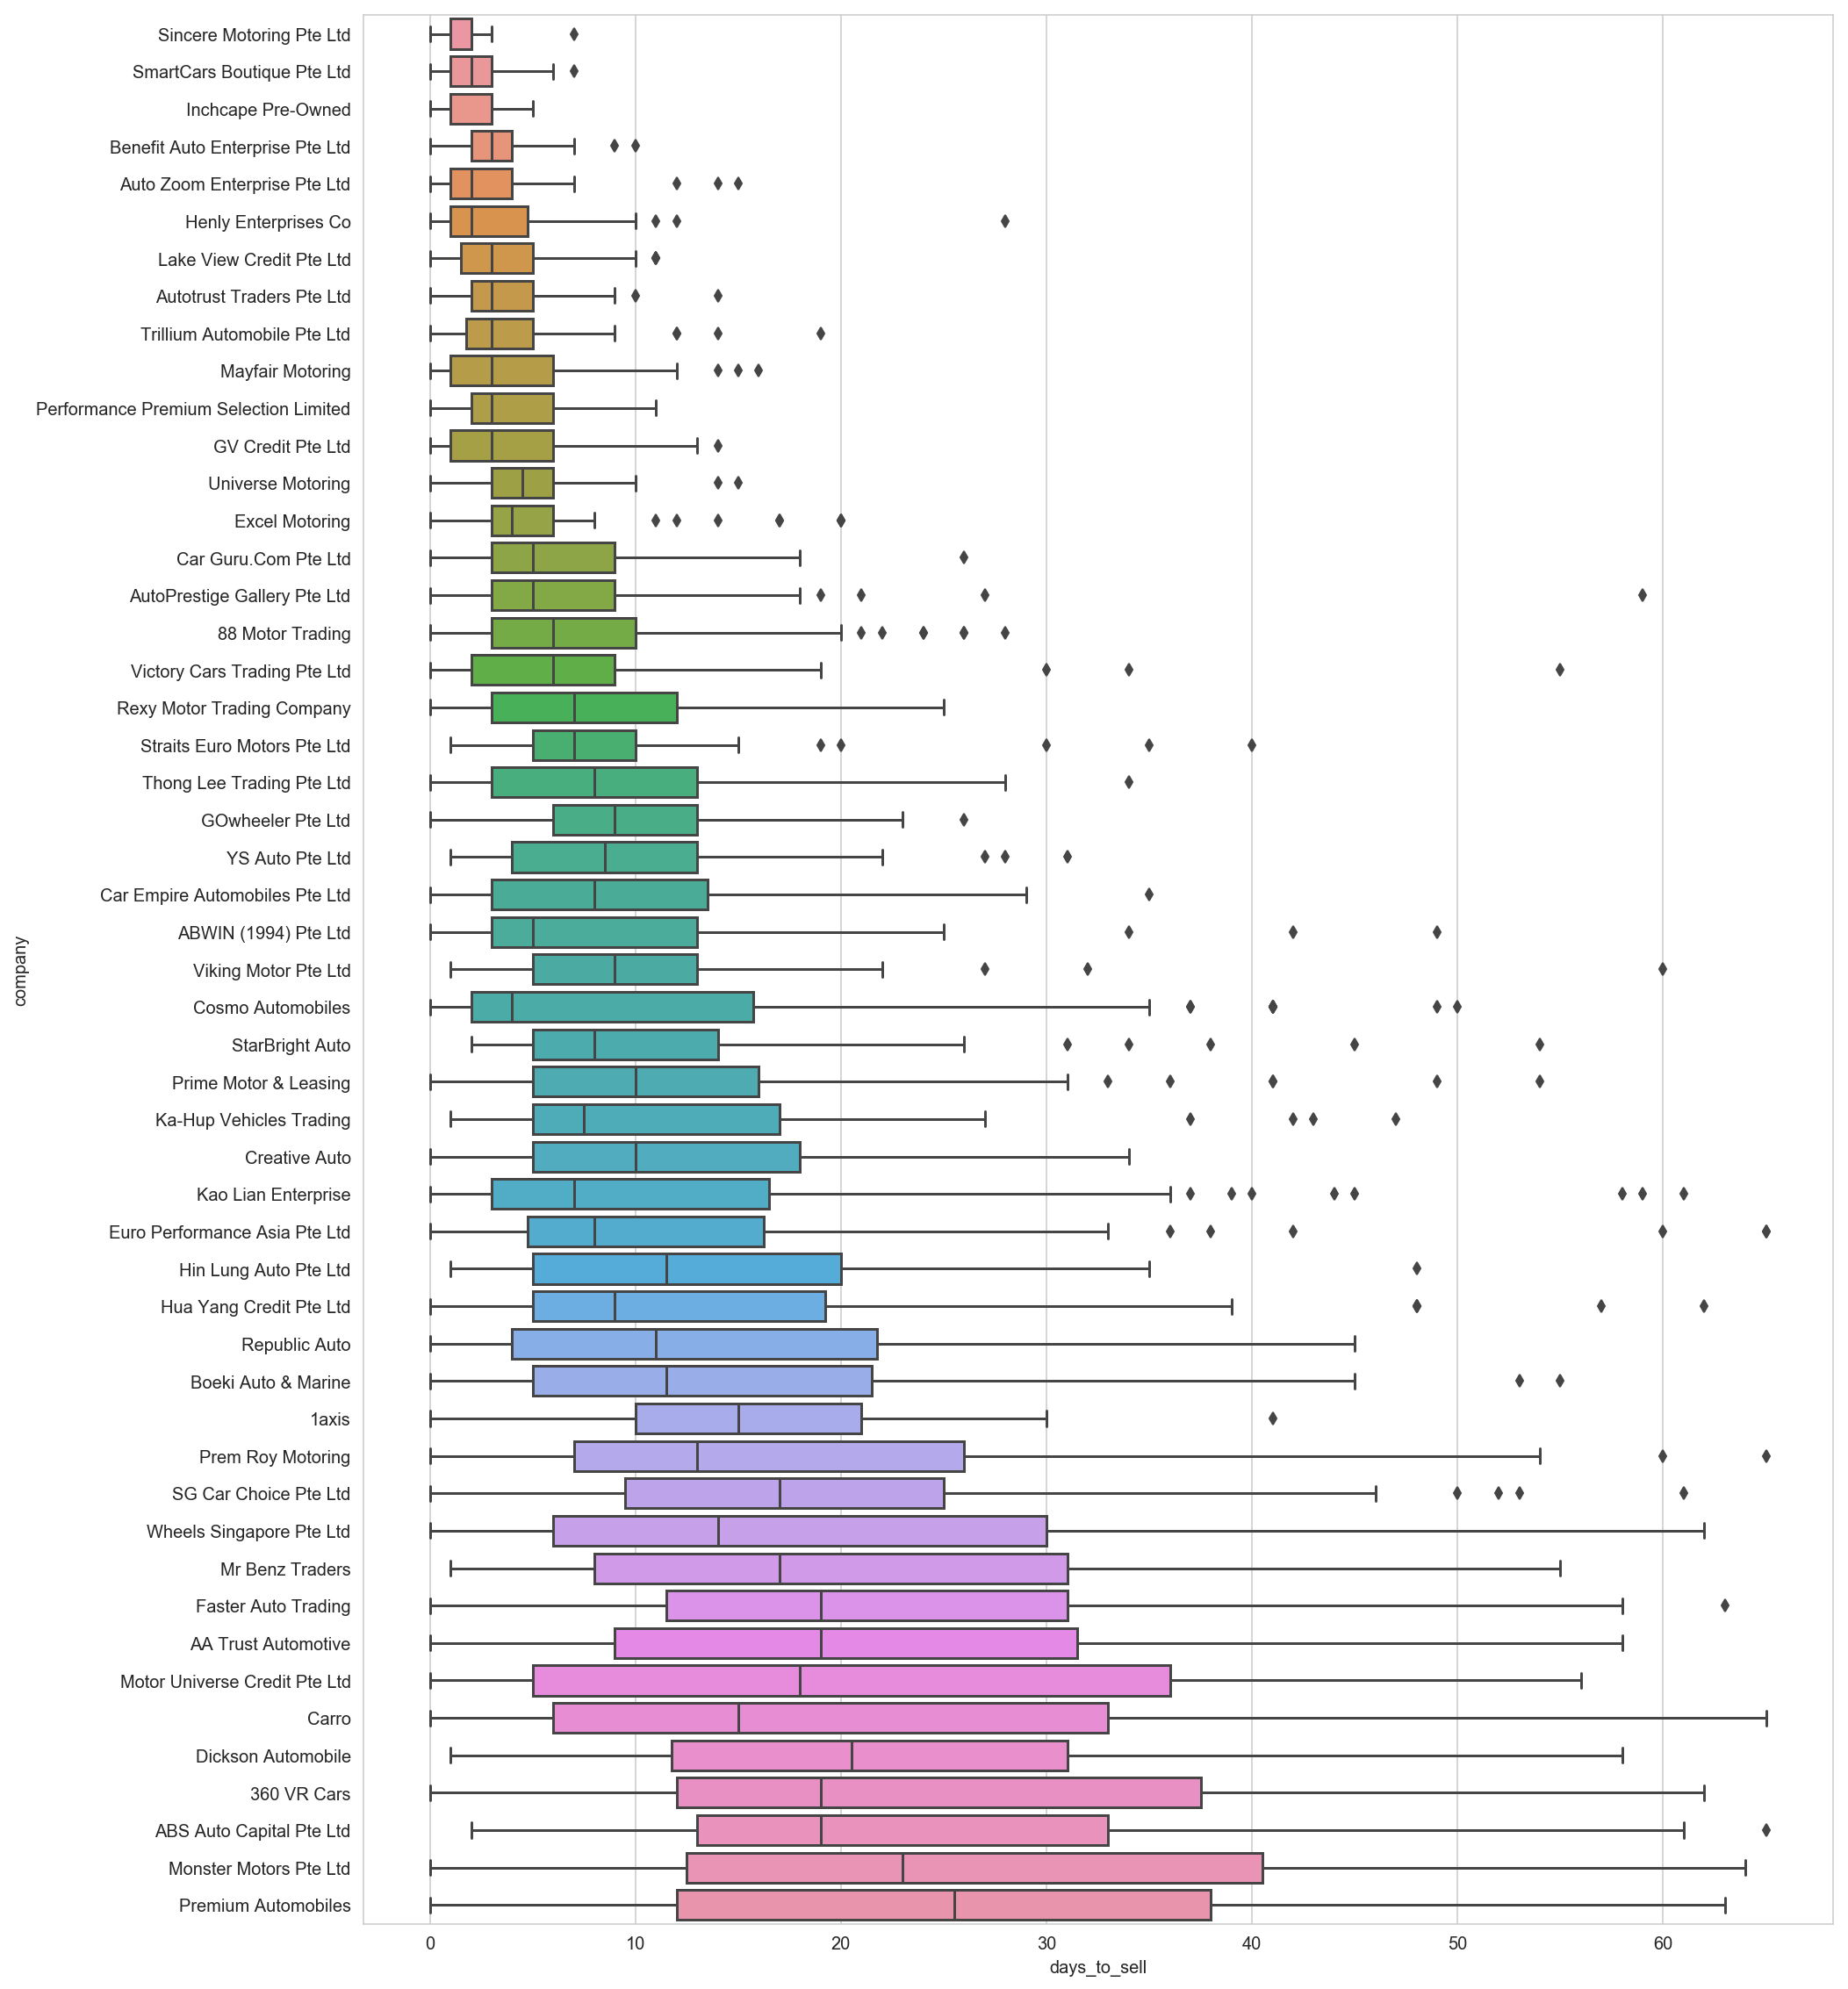

In [180]:
plt.figure(figsize=(15,20))
sns.boxplot(x=sell['days_to_sell'][isin_50],
            y=sell['company'][isin_50],orient='h',
           order = sell[['days_to_sell','company']][isin_50].groupby(by='company').mean().sort_values(by='days_to_sell').index)

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib


In [55]:
model_dums=pd.get_dummies(sell['model'],drop_first=True)
X_feats=['price','value','engine_cap','power','curb_weight','omv','mileage','veh_age_mths','month_to_coe_expiry',
         'has_renewed_COE','is_premium_ad_car','is_direct_owner_sale','is_consignment_car','is_top_dealer']
X_s=pd.DataFrame(StandardScaler().fit_transform(sell[X_feats]),columns=X_feats)
X=pd.concat([sell[X_feats],model_dums],axis=1)
Xs=pd.concat([X_s,model_dums],axis=1)
y=sell['days_to_sell']<=7
y=y.astype(int)

Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,stratify=y,random_state=123,test_size=0.2)
Xstrain,Xstest=Xs.loc[Xtrain.index],Xs.loc[Xtest.index]

/Users/zachang/Documents/Data/cars-project/env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/zachang/Documents/Data/cars-project/env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [56]:
proba=joblib.load('./flask/PROBA.pkl')

In [76]:
cross_val_class(proba,'Model',Xtest,ytest,scoring='precision')

------------------------------------

5-Fold Cross Validated Results for Model: Model
Performance Metric: precision
Cross-validated scores: [0.67487685 0.68911917 0.70050761 0.69230769 0.69565217]
Mean score: 0.6904926997418059
Std score: 0.008671266489170182


0.6904926997418059

In [63]:
proba.predict_proba(Xtest)[:,1]

array([0.27030651, 0.25253435, 0.1801051 , ..., 0.09001076, 0.5841083 ,
       0.97192741])

In [75]:
roc_auc_score(ytest,proba.predict_proba(Xtest)[:,1])

0.9970910319963948

In [77]:
print(confusion_matrix(y,proba.predict(X)))

[[6920   76]
 [ 662 5678]]


In [72]:
def cross_val_class(model,name,X,y,scoring=None,folds=5):

    '''Takes a fitted model, name, feature set and target variable and prints the cross validated score and 
    returns the mean score for the cross-validation procedure'''

    scores = cross_val_score(model, X, y, cv=folds,scoring=scoring)

    print( '------------------------------------\n')
    print('{}-Fold Cross Validated Results for Model: '.format(folds)+ name)

    if scoring==None:
        print('Performance Metric: Accuracy')
    else:
        print('Performance Metric: '+scoring)

    print("Cross-validated scores:", scores)
    print("Mean score:", np.mean(scores))
    print('Std score:', np.std(scores))

    return np.mean(scores)


In [202]:
print(rf_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [83]:
rf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500,
            oob_score=False, random_state=123)



In [84]:
xgb=XGBClassifier(gamma=0.1, learning_rate=0.15, max_depth=6, min_child_weight=3,n_estimators=500)



In [85]:
svc=SVC(kernel='rbf',probability=True)




In [86]:
knn=KNeighborsClassifier(n_neighbors=70)



In [209]:
cross_val_class(rf,'Random Forest Classifier',Xtrain,ytrain,scoring='roc_auc')
cross_val_class(xgb,'XGBoost Classifier',Xtrain,ytrain,scoring='roc_auc')
cross_val_class(svc,'Support Vector Classifier',Xstrain,ytrain,scoring='roc_auc')
cross_val_class(knn_clf,'K Nearest Neighbors Classifier',Xstrain,ytrain,scoring='roc_auc')

------------------------------------

5-Fold Cross Validated Results for Model: Random Forest Classifier
Performance Metric: roc_auc
Cross-validated scores: [0.72727676 0.72410974 0.72873754 0.71128351 0.71789165]
Mean score: 0.7218598403655895
Std score: 0.006470133988004239
------------------------------------

5-Fold Cross Validated Results for Model: XGBoost Classifier
Performance Metric: roc_auc
Cross-validated scores: [0.70699014 0.71520448 0.7011243  0.70296176 0.69854495]
Mean score: 0.7049651224437091
Std score: 0.005812557954063159


/Users/zachang/Documents/Data/cars-project/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/zachang/Documents/Data/cars-project/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/zachang/Documents/Data/cars-project/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning."

------------------------------------

5-Fold Cross Validated Results for Model: Support Vector Classifier
Performance Metric: roc_auc
Cross-validated scores: [0.68587743 0.68044842 0.69105775 0.6818727  0.69531661]
Mean score: 0.6869145837486019
Std score: 0.00558690513163158
------------------------------------

5-Fold Cross Validated Results for Model: K Nearest Neighbors Classifier
Performance Metric: roc_auc
Cross-validated scores: [0.68163024 0.69788159 0.69554228 0.69503347 0.69610866]
Mean score: 0.6932392499085257
Std score: 0.005883488981565495


0.6932392499085257

In [213]:
lrcv= LogisticRegressionCV(max_iter=2000,cv=5)
lrcv.fit(Xstrain,ytrain)



LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=2000,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [87]:
cross_val_class(rf,'Random Forest Classifier',Xtrain,ytrain,scoring='precision')
cross_val_class(xgb,'XGBoost Classifier',Xtrain,ytrain,scoring='precision')
cross_val_class(svc,'Support Vector Classifier',Xstrain,ytrain,scoring='precision')


------------------------------------

5-Fold Cross Validated Results for Model: Random Forest Classifier
Performance Metric: precision
Cross-validated scores: [0.74180865 0.74145007 0.72823219 0.71352075 0.71829105]
Mean score: 0.7286605425687158
Std score: 0.011604893749304032
------------------------------------

5-Fold Cross Validated Results for Model: XGBoost Classifier
Performance Metric: precision
Cross-validated scores: [0.70149254 0.69129917 0.67605634 0.67068758 0.6722488 ]
Mean score: 0.6823568840469625
Std score: 0.012034787550748851


/Users/zachang/Documents/Data/cars-project/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/zachang/Documents/Data/cars-project/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/zachang/Documents/Data/cars-project/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning."

------------------------------------

5-Fold Cross Validated Results for Model: Support Vector Classifier
Performance Metric: precision
Cross-validated scores: [0.85009862 0.87891441 0.84421053 0.85497835 0.8608137 ]
Mean score: 0.857803122026152
Std score: 0.011889888181805915


NameError: name 'knn_clf' is not defined

In [88]:
cross_val_class(knn,'K Nearest Neighbors Classifier',Xstrain,ytrain,scoring='precision')


------------------------------------

5-Fold Cross Validated Results for Model: K Nearest Neighbors Classifier
Performance Metric: precision
Cross-validated scores: [0.79357022 0.81684982 0.78494624 0.81346154 0.78467153]
Mean score: 0.798699868936674
Std score: 0.013853500727260316


0.798699868936674

In [19]:
joblib.dump(rf,'./flask/PROBA.pkl')





['./flask/PROBA.pkl']